# _Tensorflow implementation of paper "A Neural Algorithm of Artistic Style (2015)_"

#### _This was the breakthrough paper back then 2015. The paper shows that the pretrained convolutional network(such as VGG19) can be used to extract style and content independently from the image. They used these phenomenon to merge the content of a given image with style of reference image. The paper has great visual examples of their results. Here, we are also going to replicate the same._  

##### Step 1: Preprocessing the input image

##### Step 2: Computing the output for selected layers for the content image and all the layers for style image.

##### Step 3: What are loss functions in this problem and computing the loss functions.
      Step 3A: Content Loss for reconstruction of the content image.
      Step 3B: Style Loss for reconstruction of the style from a style image irrespective of content placement of the image.
##### Step 4: Creating combined Tensorflow model, running it to minimize both the losses and optimize the input noise variable.

##### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Step 1: Preprocessing the input image

_Note: Here, we have used VGG16 layer instead of VGG19 layer (which was used in the paper.) but both can perform the job. Also, as suggested by the authors' of the paper, we have used average pooling instead of max pooling.
Here, because we just want to compute output of convolution layers not fully connected layers, we can have any size of input image we want._


In [1]:
import numpy as np
import helper
import tf_helper
import tensorflow as tf
from PIL import Image
from tensorflow_vgg import vgg16_avg_pool
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### The "helper.py" will help us preprocess and post process the input image. 

#### The "tf_helper.py" will help us compute all the layers-outputs of a given image from VGG16 network. This values will be used later in the actual session. 

Content File


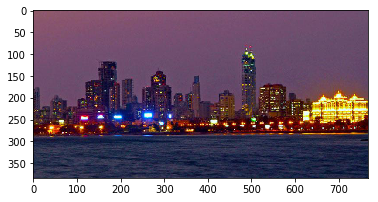

Style File


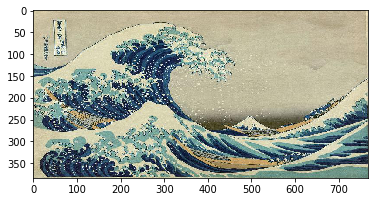

In [2]:
content_folder = "./image_resources/content/"
content_file = "content_4"
style_folder = "./image_resources/style/"
style_file = "style_4"

output_path = "./image_resources/processed/"

content_output_file = content_file + "_processed.jpg"
style_output_file = style_file + "_processed.jpg"

# The following functions will scale the style image as per content image, save it and 
# scale content image and style image pixel value to [0-1] as the model expects the input to be between o and 1
# Lastly, it will make a tensorflow ready numpy array with [1, w, h, 3] dims

content_array = helper.resize_and_rescale_img_content(content_folder + content_file + ".jpg", output_path, content_output_file)
style_array = helper.resize_and_rescale_img_style(content_folder + content_file + ".jpg", style_folder + style_file + ".jpg", output_path, style_output_file)

i = Image.open(output_path + content_output_file)
j = Image.open(output_path + style_output_file)
print("Content File")
plt.imshow(np.array(i).astype(np.uint8))
plt.show()
print("Style File")
plt.imshow(np.array(j).astype(np.uint8))
plt.show()

##### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Step 2: Computing the output for all the layers for the input image. (This will be used later in loss function) 

In [3]:
# Here, we will pre-compute the outputs of all the layers for the given style image and content image.

content_output = tf_helper.compute_tf_output(content_array)
style_output = tf_helper.compute_tf_output(style_array)

/home/patelmeet2012/notebooks/A-Neural-Algorithm-of-Artistic-Style-Paper-Implementation/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
All layers' outputs have been computed sucessfully.
/home/patelmeet2012/notebooks/A-Neural-Algorithm-of-Artistic-Style-Paper-Implementation/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
All layers' outputs have been computed sucessfully.


##### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Step 3: What are loss function in this problem and computing the loss functions.

#### _Step 3A: Content Loss for reconstruction of the content image._

The content loss is the mean squared difference between feature representation of content image and random noise. The feature representation can be taken from the different layers of the VGG16 model. The each feature representation can be visualized as per below image. Source of the image: https://www.youtube.com/watch?v=CzN_-gVgTno

![](Other resources/Feature representation matrix visualized.PNG)

![](Other resources/Content Loss.PNG)

Below, we have tried to generate the content of the content image from random noise. As you go throught the results you might notice that as we select deeper layer in VGG16 model the precise representation is getting lost. From initial layers we can generate almost exact image, but as we go deeper the exact detailing is getting lost.

In [4]:
# Only image content reconstruction : Content loss

def content_reconstruction(c_output, content_layer_no, f_name, l_r):
    tf.reset_default_graph()

    vgg = vgg16_avg_pool.Vgg16()

    init_rand = tf.random_uniform(shape=content_array.shape, minval=0, maxval=1)
    input_noise_variable = tf.Variable(initial_value=init_rand, name="input_noise", dtype=tf.float32)

    vgg.build(input_noise_variable)

    noise_layers = [vgg.conv1_1, vgg.conv2_1, vgg.conv3_1, vgg.conv4_1, vgg.conv5_1]

    noise_layers_list = dict({0: vgg.conv1_1, 1: vgg.conv1_2, 2: vgg.pool1, 3: vgg.conv2_1, 4: vgg.conv2_2, 5: vgg.pool2, 6: vgg.conv3_1, 7: vgg.conv3_2, 
               8: vgg.conv3_3, 9: vgg.pool3, 10: vgg.conv4_1, 11: vgg.conv4_2, 12: vgg.conv4_3, 13: vgg.pool4, 14: vgg.conv5_1, 15: vgg.conv5_2, 
               16: vgg.conv5_3, 17: vgg.pool5 })
    
    content_part = np.squeeze(c_output[content_layer_no])
    content_part = np.reshape(content_part, (content_part.shape[0] * content_part.shape[1], content_part.shape[2]))

    c_noise_part = tf.squeeze(noise_layers_list[content_layer_no])
    c_noise_part = tf.reshape(c_noise_part, (c_noise_part.shape[0] * c_noise_part.shape[1], c_noise_part.shape[2]))
    content_loss =  tf.reduce_sum((c_noise_part - content_part)**2) / 2
    
    opt = tf.train.AdamOptimizer(l_r).minimize(content_loss)

    epochs = 1000

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        initial_noise = sess.run(input_noise_variable)
        for i in range(epochs):
            _, l = sess.run([opt, content_loss])
            if (i+1) % 100 == 0:
                print("Epoch: {}/{}, Content Loss: {}".format(i+1, epochs, l))
                final_noise = sess.run(input_noise_variable)
                # post process the output so that it can be represented properly
                # normalized the data for better visualization
                final_noise = helper.post_process_and_display(final_noise, "./image_resources/outputs/", f_name + ".jpg")
        final_noise = sess.run(input_noise_variable)
        final_noise = helper.post_process_and_display(final_noise, "./image_resources/outputs/", f_name + ".jpg")
    return final_noise

/home/patelmeet2012/notebooks/A-Neural-Algorithm-of-Artistic-Style-Paper-Implementation/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Epoch: 100/1000, Content Loss: 3978034688.0


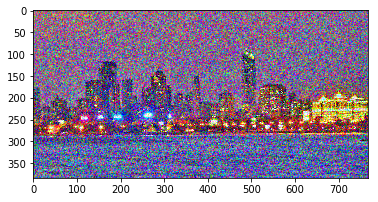

Epoch: 200/1000, Content Loss: 1258774784.0


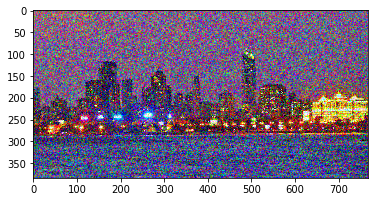

Epoch: 300/1000, Content Loss: 360018880.0


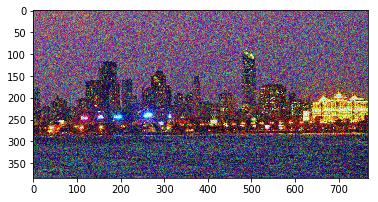

Epoch: 400/1000, Content Loss: 178728368.0


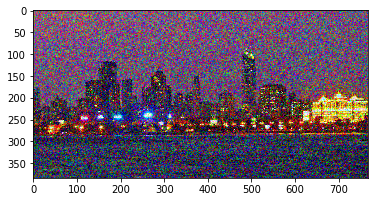

Epoch: 500/1000, Content Loss: 105315464.0


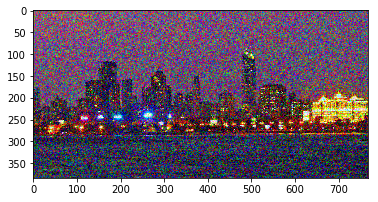

Epoch: 600/1000, Content Loss: 91258088.0


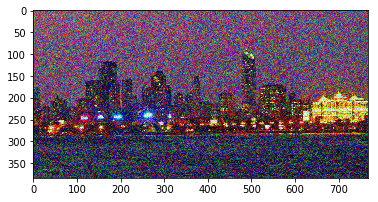

Epoch: 700/1000, Content Loss: 163941248.0


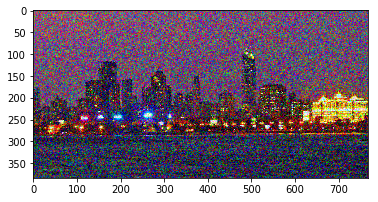

Epoch: 800/1000, Content Loss: 90591096.0


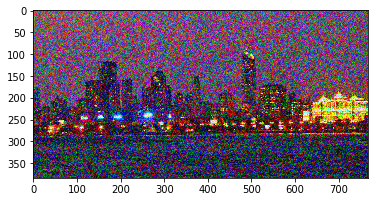

Epoch: 900/1000, Content Loss: 75831024.0


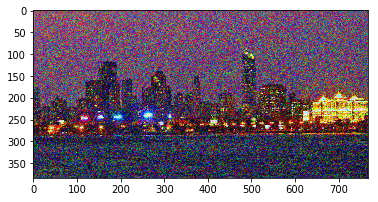

Epoch: 1000/1000, Content Loss: 143347424.0


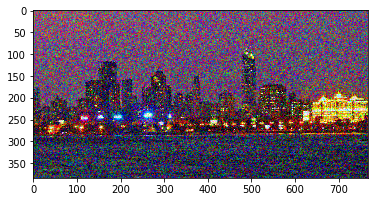

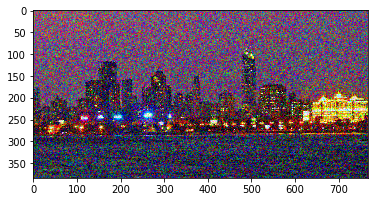

In [9]:
layer_no = 6                               # to select vgg.conv3_1 from noise_layers list
file_name = content_file + "_conv3_1"
content_generation = content_reconstruction(c_output=content_output, content_layer_no=layer_no, 
                                                        f_name=file_name, l_r=0.02)

#### Generate output for 5 different configuration - 5 different layers and Visualize all the outputs.

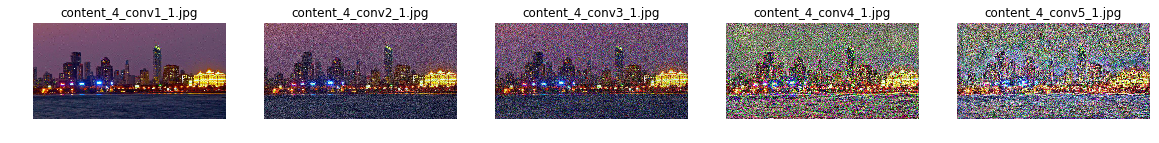

In [12]:
file_name_pre = content_file + "_conv"
file_name_post = "_1.jpg"

fig = plt.figure(figsize=(20, 20))

cols = 5
rows = 1

for j in range(cols*rows):    
    im = Image.open("./image_resources/outputs/" + file_name_pre + str(j+1) + file_name_post)
    im = np.asarray(im, np.uint8)
    fig.add_subplot(rows, cols, j+1)
    plt.imshow(im)
    plt.title(file_name_pre + str(j+1) + file_name_post)
    plt.axis('off')

As you can see, the deeper layer we use, the distorted the reconstruction will be. Also, the exact representation is little bit manipulated. This insight will be used in the further implementation.

##### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### _Step 3B: Style Loss for reconstruction of the style from a style image irrespective of content placement of the image._

The Style loss is similar to content loss. But instead of computing the mean squared difference on feature representation, the authors' have used Gram Matrix. The Gram Matrix is nothing but the matrix multiplication between transposed feature representation and feature representation. It shows how much a filter is related to other filters in a given layer. The higher the product the higher they are likely to be related to each other. So the style loss will be mean square error between gram matrix of style image and random noise. The following visualization can help further understand it. Source of the image: https://www.youtube.com/watch?v=CzN_-gVgTno

![](Other resources/Gram Matrix Visualized.PNG)

![](Other resources/Style Loss-1.PNG)
![](Other resources/Style Loss-2.PNG)

In [13]:
# Only style reconstruction : Style loss

def style_reconstruction(weights, s_output, f_name, l_r):
    tf.reset_default_graph()

    vgg = vgg16_avg_pool.Vgg16()

    init_rand = tf.random_uniform(shape=style_array.shape, minval=0, maxval=1)
    input_noise_variable = tf.Variable(initial_value=init_rand, name="input_noise", dtype=tf.float32)

    vgg.build(input_noise_variable)

    noise_layers_list = dict({0: vgg.conv1_1, 1: vgg.conv1_2, 2: vgg.pool1, 3: vgg.conv2_1, 4: vgg.conv2_2, 5: vgg.pool2, 6: vgg.conv3_1, 7: vgg.conv3_2, 
               8: vgg.conv3_3, 9: vgg.pool3, 10: vgg.conv4_1, 11: vgg.conv4_2, 12: vgg.conv4_3, 13: vgg.pool4, 14: vgg.conv5_1, 15: vgg.conv5_2, 
               16: vgg.conv5_3, 17: vgg.pool5 })

    style_loss = tf.constant(0, dtype=tf.float32, name="Loss")
    for i in range(len(weights)):
        style_part = np.squeeze(s_output[weights[i][0]])
        style_part = np.reshape(style_part, (style_part.shape[0] * style_part.shape[1], style_part.shape[2]))
        style_gram_matrix = np.matmul(style_part.T, style_part)

        s_noise_part = tf.squeeze(noise_layers_list[weights[i][0]])
        s_noise_part = tf.reshape(s_noise_part, (s_noise_part.shape[0] * s_noise_part.shape[1], s_noise_part.shape[2]))
        noise_gram_matrix = tf.matmul(tf.transpose(s_noise_part), s_noise_part)
        
        s_denominator = (4 * (s_noise_part.get_shape().as_list()[1]**2) * (s_noise_part.get_shape().as_list()[0]**2))
        
        style_loss += weights[i][1] * tf.reduce_sum((noise_gram_matrix - style_gram_matrix)**2) / tf.cast(s_denominator, tf.float32)
        
    style_loss = style_loss / len(weights)
    
    opt = tf.train.AdamOptimizer(l_r).minimize(style_loss)

    epochs = 1000

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        initial_noise = sess.run(input_noise_variable)
        for i in range(epochs):
            _, l = sess.run([opt, style_loss])
            if (i+1) % 100 == 0:
                print("Epoch: {}/{}, Style Loss: {}".format(i+1, epochs, l))
                final_noise = sess.run(input_noise_variable)
                final_noise = helper.post_process_and_display(final_noise, "./image_resources/outputs/", f_name + ".jpg")
        
        final_noise = sess.run(input_noise_variable)
        final_noise = helper.post_process_and_display(final_noise, "./image_resources/outputs/", f_name + ".jpg")
    return final_noise

/home/patelmeet2012/notebooks/A-Neural-Algorithm-of-Artistic-Style-Paper-Implementation/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Epoch: 100/1000, Style Loss: 1986705.0


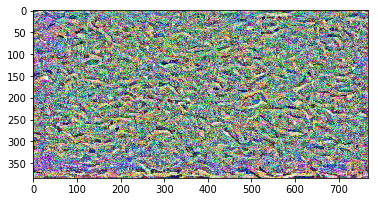

Epoch: 200/1000, Style Loss: 951471.0


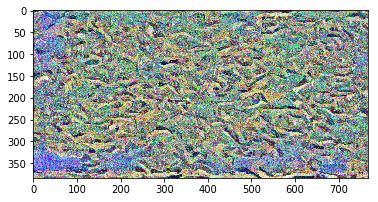

Epoch: 300/1000, Style Loss: 634186.1875


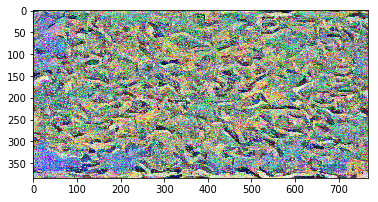

Epoch: 400/1000, Style Loss: 416314.875


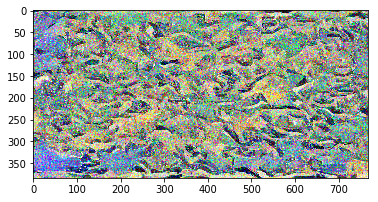

Epoch: 500/1000, Style Loss: 253230.171875


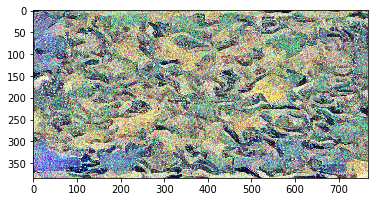

Epoch: 600/1000, Style Loss: 149350.546875


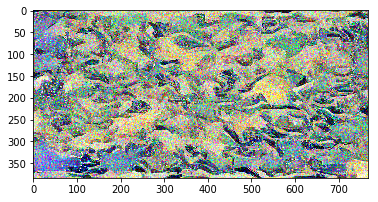

Epoch: 700/1000, Style Loss: 89477.546875


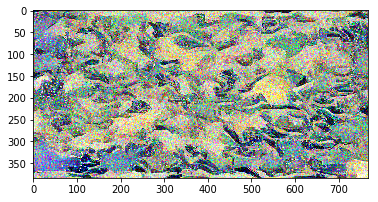

Epoch: 800/1000, Style Loss: 56096.63671875


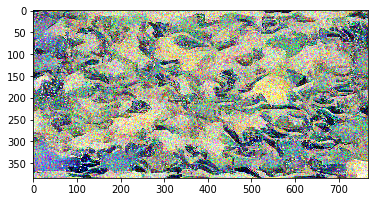

Epoch: 900/1000, Style Loss: 37345.76171875


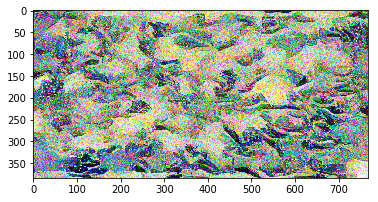

Epoch: 1000/1000, Style Loss: 26580.99609375


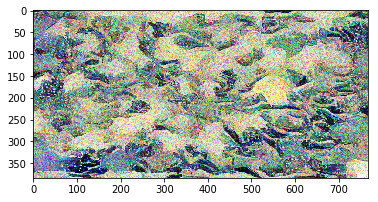

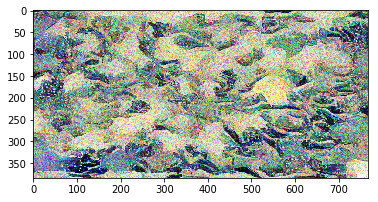

In [14]:
layer_weights = [(0, 1), (3, 1), (6, 1)]
file_name = style_file + "_conv1_1, conv2_1 and conv3_1"

style_reconstructions = style_reconstruction(weights=layer_weights, s_output=style_output, f_name=file_name, l_r=0.2)

#### Generate outputs for 5 different configuration as per paper and Visualize them.

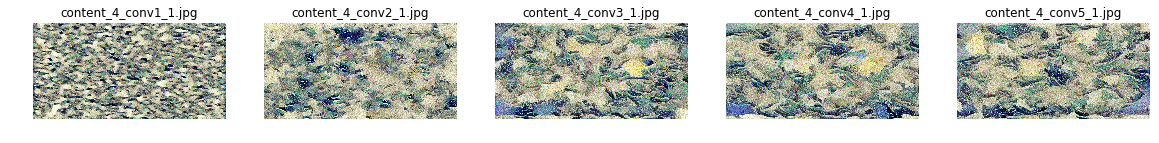

In [19]:
file_names = ["_conv1_1", "_conv1_1 and conv2_1", "_conv1_1, conv2_1 and conv3_1", "_conv1_1, conv2_1, conv3_1 and conv4_1", "_conv1_1, conv2_1, conv3_1, conv4_1 and conv5_1"]

fig = plt.figure(figsize=(20, 20))

cols = 5
rows = 1

for j in range(cols*rows):    
    im = Image.open("./image_resources/outputs/" + style_file + file_names[j] + ".jpg")
    im = np.asarray(im, np.uint8)
    fig.add_subplot(rows, cols, j+1)
    plt.imshow(im)
    plt.title(file_name_pre + str(j+1) + file_name_post)
    plt.axis('off')

##### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Step 4: Creating combined Tensorflow model, running it to minimize both the losses and optimize the input noise variable.

Now in order to generate combined image, we need to minimize total loss = content loss + style loss. As per the paper, the authors' have used weighted sum for that to give variable importance to content loss and style loss instead of giving equal importance.

![](Other resources/Total Loss-1.PNG)
![](Other resources/Total Loss-2.PNG)

Along with these two losses (content loss and style loss), here I have included one more loss: denoising loss which is helpful in reducing the noise in the generated image. The details can be found here: https://www.youtube.com/watch?v=LoePx3QC5Js&t=1150s and https://github.com/tensorflow/tensorflow/issues/6397

In [20]:
def style_transfer(style_configurations, content_configurations, s_output, c_output, alpha, beta, gamma, l_r, f_name):
    tf.reset_default_graph()

    vgg = vgg16_avg_pool.Vgg16()

    init_rand = tf.random_uniform(shape=content_array.shape, minval=0, maxval=1)
    input_noise_variable = tf.Variable(initial_value=init_rand, name="input_noise", dtype=tf.float32)

    vgg.build(input_noise_variable)

    noise_layers_list = dict({0: vgg.conv1_1, 1: vgg.conv1_2, 2: vgg.pool1, 3: vgg.conv2_1, 4: vgg.conv2_2, 5: vgg.pool2, 6: vgg.conv3_1, 7: vgg.conv3_2, 
               8: vgg.conv3_3, 9: vgg.pool3, 10: vgg.conv4_1, 11: vgg.conv4_2, 12: vgg.conv4_3, 13: vgg.pool4, 14: vgg.conv5_1, 15: vgg.conv5_2, 
               16: vgg.conv5_3, 17: vgg.pool5 })
    
    ### Content Loss
    content_part = np.squeeze(c_output[content_configurations])
    content_part = np.reshape(content_part, (content_part.shape[0] * content_part.shape[1], content_part.shape[2]))

    noise_part_c = tf.squeeze(noise_layers_list[content_configurations])
    noise_part_c = tf.reshape(noise_part_c, (noise_part_c.shape[0] * noise_part_c.shape[1], noise_part_c.shape[2]))
    content_loss =  tf.reduce_sum((noise_part_c - content_part)**2) / 2
    content_loss *= alpha
    
    ### Style Loss
    style_loss = tf.constant(0, dtype=tf.float32, name="Loss")
    for i in range(len(style_configurations)):
        style_part = np.squeeze(s_output[style_configurations[i][0]])
        style_part = np.reshape(style_part, (style_part.shape[0] * style_part.shape[1], style_part.shape[2]))
        style_gram_matrix = np.matmul(style_part.T, style_part)

        noise_part_s = tf.squeeze(noise_layers_list[style_configurations[i][0]])
        noise_part_s = tf.reshape(noise_part_s, (noise_part_s.shape[0] * noise_part_s.shape[1], noise_part_s.shape[2]))
        noise_gram_matrix = tf.matmul(tf.transpose(noise_part_s), noise_part_s)

        s_denominator = (4 * (noise_part_s.get_shape().as_list()[1]**2) * (noise_part_s.get_shape().as_list()[0]**2))
        
        style_loss += style_configurations[i][1] * tf.reduce_sum((noise_gram_matrix - style_gram_matrix)**2) / tf.cast(s_denominator, tf.float32)

    style_loss = style_loss / len(style_configurations)
    style_loss = beta * style_loss
    
    ### denoising loss: as suggested by few implementations to reduce the noise in the generated image
    denoising_loss = tf.reduce_sum(tf.abs(input_noise_variable[:, 1:, :, :] - input_noise_variable[:, :-1, :, :])) + \
                        tf.reduce_sum(tf.abs(input_noise_variable[:, :, 1:, :] - input_noise_variable[:, :, :-1, :])) 
    
    denoising_loss *= gamma
    
    total_loss = content_loss + style_loss + denoising_loss
    
    opt = tf.train.AdamOptimizer(l_r).minimize(total_loss)
    
    epochs = 1000

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        initial_noise = sess.run(input_noise_variable)
        for i in range(epochs):
            _, l = sess.run([opt, total_loss])
            if (i+1) % 100 == 0:
                c_l, s_l, d_l = sess.run([content_loss, style_loss, denoising_loss])
                print("Epoch: {}/{}, Content Loss: {}, Style Loss: {}, Denoising Loss: {}, Total Loss: {}".format(i+1, epochs, c_l, s_l, d_l, l))
                final_noise = sess.run(input_noise_variable)
                final_noise = helper.post_process_and_display(final_noise, "./image_resources/outputs/", f_name + ".jpg")
        final_noise = sess.run(input_noise_variable)
        final_noise = helper.post_process_and_display(final_noise, "./image_resources/outputs/", f_name + ".jpg")
    return final_noise

As per Part 3A, it is better to use the initial layers for the exact reconstruction of the content image, but if we need to merge style of reference image with content of the given image then exact reconstruction is not required as we should give our model some freedom to manipulate the content image a bit to facilitate the style of the reference image. 


Now lets reconstruct the results of the paper using as per the configuration provided in the paper

Content loss calculated on conv4_2 layer in VGG19, but in our case it is VGG16's conv4_2 layer.

Style loss calculated on conv1_1, conv2_1, conv3_1, conv4_1 and conv5_1 with weights = 1/5 for each layer.

alpha / beta = 1 x 10-3

**Note: The selection of the parameters : alpha, beta, gamma and learning_rate will be purely based on the selection of content image and style image. It may happen that the parameters that worked best for one set of images may not work well for other set of images. So keep experiementing until you find the best results.**

/home/patelmeet2012/notebooks/A-Neural-Algorithm-of-Artistic-Style-Paper-Implementation/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Epoch: 100/1000, Content Loss: 2456005632.0, Style Loss: 1759743744.0, Denoising Loss: 271234624.0, Total Loss: 4518471168.0


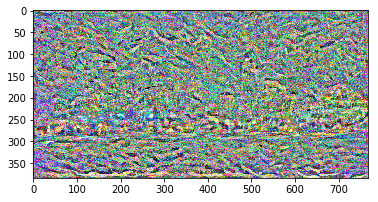

Epoch: 200/1000, Content Loss: 1592598400.0, Style Loss: 1060311680.0, Denoising Loss: 256564224.0, Total Loss: 2916966144.0


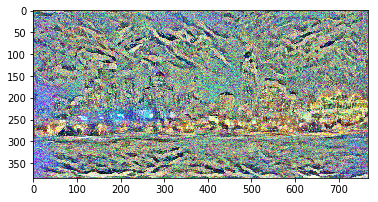

Epoch: 300/1000, Content Loss: 1319120640.0, Style Loss: 838363968.0, Denoising Loss: 238826336.0, Total Loss: 2400046592.0


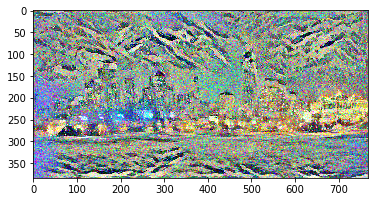

Epoch: 400/1000, Content Loss: 1186441216.0, Style Loss: 687175680.0, Denoising Loss: 219520000.0, Total Loss: 2095649024.0


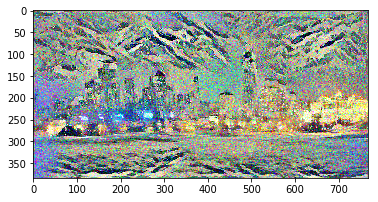

Epoch: 500/1000, Content Loss: 1102871168.0, Style Loss: 577788416.0, Denoising Loss: 199424192.0, Total Loss: 1881965184.0


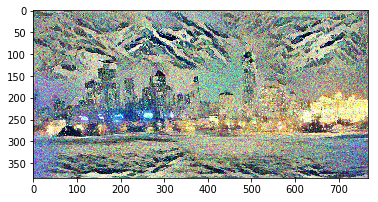

Epoch: 600/1000, Content Loss: 1041756736.0, Style Loss: 508398464.0, Denoising Loss: 179317904.0, Total Loss: 1730793984.0


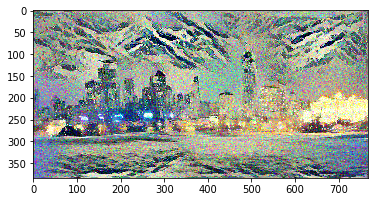

Epoch: 700/1000, Content Loss: 994377600.0, Style Loss: 467261664.0, Denoising Loss: 159814656.0, Total Loss: 1622236672.0


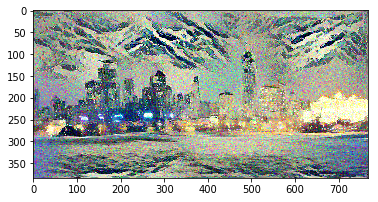

Epoch: 800/1000, Content Loss: 952410944.0, Style Loss: 443805152.0, Denoising Loss: 141560336.0, Total Loss: 1538623616.0


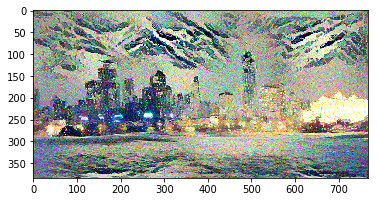

Epoch: 900/1000, Content Loss: 920670464.0, Style Loss: 430516608.0, Denoising Loss: 124987408.0, Total Loss: 1476802688.0


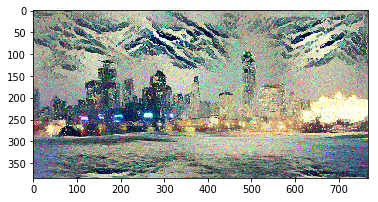

Epoch: 1000/1000, Content Loss: 896959616.0, Style Loss: 421801216.0, Denoising Loss: 110427240.0, Total Loss: 1427896704.0


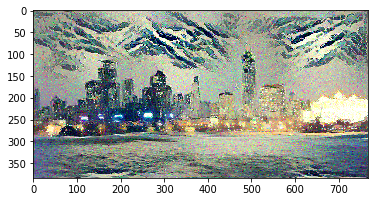

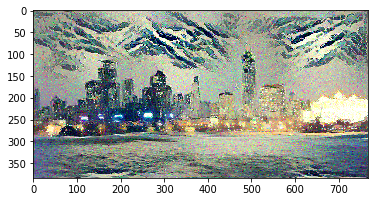

In [23]:
style_transfer_config = [(0, 1), (3, 1), (6, 1), (10, 1), (14, 1)]
content_transfer_config = 11
file_name = "style_transfer_C4_S4"

style_transfer_outputs = style_transfer(style_transfer_config, content_transfer_config, style_output, content_output, 
                                        alpha=1, beta=1000, gamma=500, l_r=0.2, f_name=file_name)